In [63]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [64]:
x_train = pd.read_csv('data/X_train.csv', header=None)
y_train = pd.read_csv('data/y_train.csv', header=None, dtype=int)
y_train.rename(columns={y_train.columns[0]: 'class'}, inplace=True)

x_test = pd.read_csv('data/X_test.csv', header=None)
y_test = pd.read_csv('data/y_test.csv', header=None, dtype=int)
y_test.rename(columns={y_train.columns[0]: 'class'}, inplace=True)

# 4.1 Data understanding and preprocessing

In [65]:
class_freq = y_train.value_counts(normalize=True).sort_index()
print("Remaining test classes with counts:\n", class_freq)

Remaining test classes with counts:
 class
0        0.520875
1        0.095511
2        0.252728
3        0.046940
4        0.083946
dtype: float64


# 4.2 Principal component analysis

In [66]:
from sklearn.decomposition import PCA
from sklearn import datasets

Normalize data

In [67]:
means = x_train.mean()
x_train = (x_train - means) / x_train.std()
x_test = (x_test - means) / x_train.std()

In [68]:
pca = PCA()
pca.fit(x_train);

### Explained Variance
We need 5 components to explain 90% of the variance.

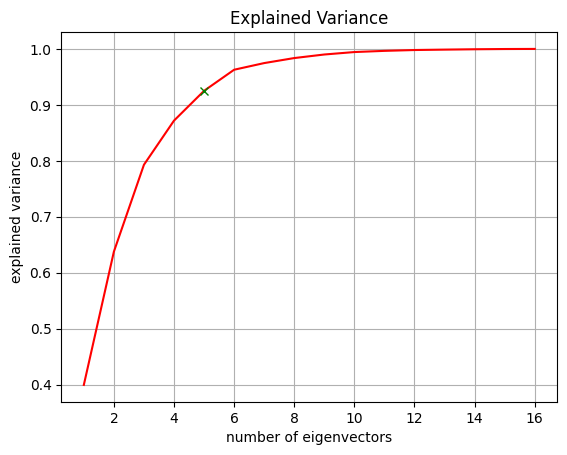

In [69]:
explained_variance = pca.explained_variance_ / np.sum(pca.explained_variance_)
cumsum = np.cumsum(explained_variance)

# Uncomment for explained variance plot
plt.plot(np.arange(1, len(explained_variance) + 1), cumsum, '-r', label='eigenvalue number')
plt.plot(5, cumsum[4], '-g', marker="x")
plt.xlabel("number of eigenvectors")
plt.ylabel("explained variance")
plt.grid(True)
plt.title(f"Explained Variance")
plt.savefig("images/4_2_explained_variance.png")
plt.show();

### Eigenspectrum

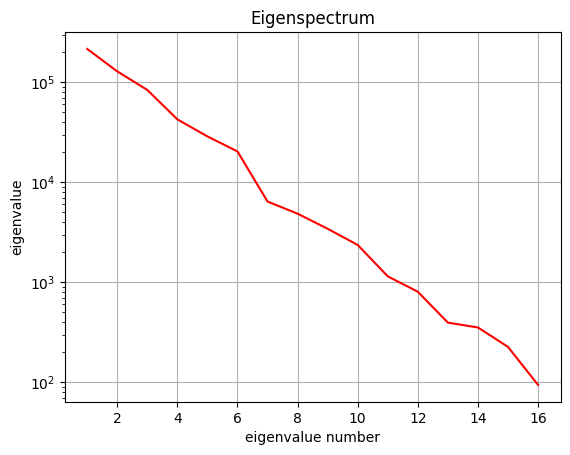

In [70]:
xs = np.arange(1, len( pca.singular_values_) + 1)
plt.plot(xs,  pca.singular_values_**2, '-r', label='eigenvalue number')
plt.xlabel("eigenvalue number")
plt.ylabel("eigenvalue")
plt.yscale('log')
plt.title(f"Eigenspectrum")
plt.grid(True)
plt.savefig("images/4_2_eigenspectrum.png")
plt.show()

### 2-PCA scatter

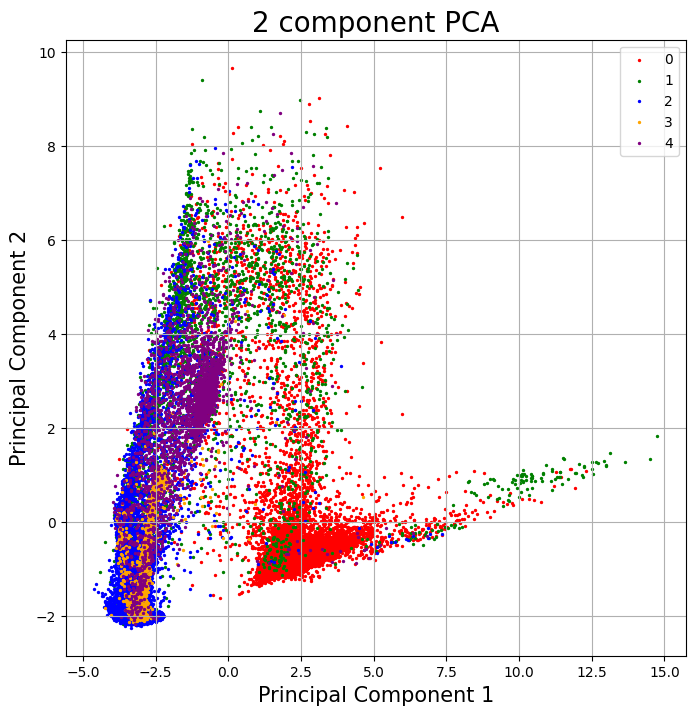

In [71]:
x_transformed = pca.transform(x_train)[:,:2]
pca_df = pd.DataFrame(data=x_transformed, columns=['pca1', 'pca2'])
x = pd.concat([pca_df, y_train], axis=1)

colors = ['r', 'g', 'b', 'orange', 'purple']
def plot(df, colors):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)

    targets = y_train['class'].unique()
    for target, color in zip(targets, colors):
        indicesToKeep = df['class'] == target
        ax.scatter(df.loc[indicesToKeep, 'pca1']
                , df.loc[indicesToKeep, 'pca2']
                , c = color
                , s = 2)
    ax.legend(targets)
    ax.grid()

    return fig, ax

plot(x, colors)
plt.savefig("images/pca.png");

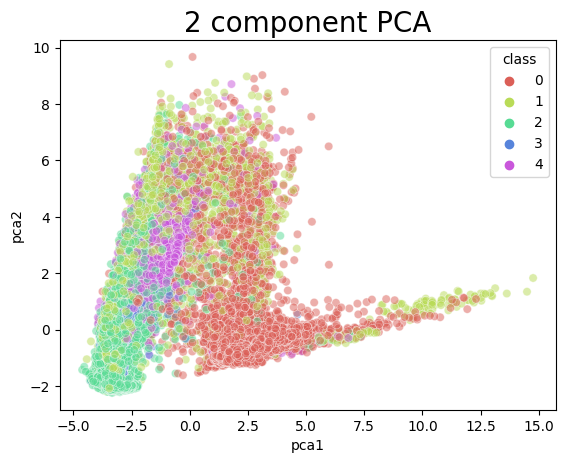

In [72]:
sns.scatterplot(
    x="pca1", y="pca2",
    hue="class",
    palette=sns.color_palette("hls", 5),
    data=x,
    legend="full",
    alpha=0.5
).set_title('2 component PCA', fontsize = 20);

# 4.3 Clustering
5-means using k-means++ (default)

In [73]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

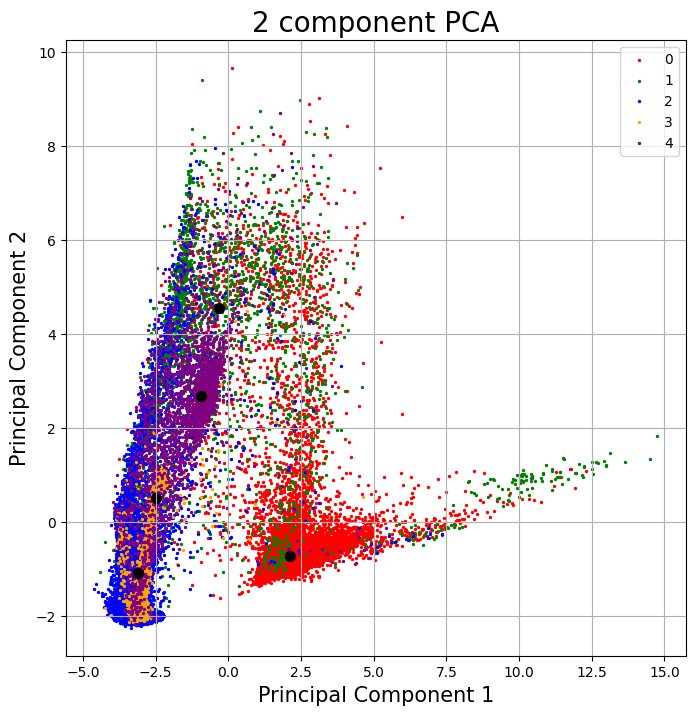

In [74]:
clusters = 5
means4 = KMeans(clusters)
means4.fit(x_train)

fig, ax = plot(x, colors)
# PCA transform normalizes data
means4_centers = pca.transform(means4.cluster_centers_)
ax.scatter(means4_centers[:, 0], means4_centers[:, 1], c='black', s=50);

In [75]:
# tsne = TSNE(n_components=2, perplexity=30)
# train = pd.concat([x_train, y_train], axis=1)
# tsne_results = tsne.fit_transform(x);

In [76]:
# x['tsne-2d-one'] = tsne_results[:,0]
# x['tsne-2d-two'] = tsne_results[:,1]

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="class",
#     palette=sns.color_palette("hls", 10),
#     data=x,
#     legend="full",
#     alpha=0.3
# );

# 4.4 Classification

### Multi-nominal logistic regression

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV, Lasso
from sklearn.linear_model import RidgeCV, Ridge

In [98]:
def plot(x, y, score, slope, intercept):
    fitted_line = np.dot(x, slope.T) + intercept
    fig = plt.figure()
    plt.title("Test set performance\nTest score: %.3f"%(score))
    #ax = Axes3D(fig)
    ax = plt.axes(projection ='3d')
    ax.scatter(x, y, c='blue', label='Truths')
    ax.plot(x, fitted_line, color='k', label='Fitted line')
    ax.set_xlabel('age')
    ax.set_ylabel('temperature')
    ax.set_zlabel('length')
    plt.legend()
    plt.show()

In [103]:
# Train logistic regression
logreg = LogisticRegression(penalty='none', fit_intercept=True, multi_class='multinomial', solver='newton-cg', max_iter=500)
logreg.fit(x_train, y_train.squeeze())
# Get model parameters
ws = logreg.coef_
bs = logreg.intercept_
# Evaluate model
train_score = logreg.score(x_train, y_train)
test_score = logreg.score(x_test, y_test)
print("Training error:", train_score, "Test error:", test_score);

Training error: 0.8502550112679398 Test error: 0.8538954032084023


In [104]:
lasso = LassoCV(fit_intercept=True, random_state=0)
lasso.fit(x_train, y_train.squeeze())
# Get model parameters
lasso_ws = lasso.coef_
lasso_bs = lasso.intercept_
# Evaluate model
train_score = lasso.score(x_train, y_train)
test_score = lasso.score(x_test, y_test)
print("Training error:", train_score, "Test error:", test_score)

Training error: 0.7931921134867302 Test error: 0.7608697308152205


### Random forests

In [79]:
from sklearn.ensemble import RandomForestClassifier

In [80]:
# 50 trees
rf_50 = RandomForestClassifier(n_estimators=50, max_features='sqrt', bootstrap=True, criterion='gini', random_state=0, n_jobs=4).fit(x_train, y_train.squeeze())
rf_100 = RandomForestClassifier(n_estimators=100, max_features='sqrt', bootstrap=True, criterion='gini', random_state=0, n_jobs=4).fit(x_train, y_train.squeeze())
rf_200 = RandomForestClassifier(n_estimators=200, max_features='sqrt', bootstrap=True, criterion='gini', random_state=0, n_jobs=4).fit(x_train, y_train.squeeze());

In [81]:
print("RF50 training error:", rf_50.score(x_train, y_train), "test error:", rf_50.score(x_test, y_test))
print("RF100 training error:", rf_100.score(x_train, y_train), "test error:", rf_100.score(x_test, y_test))
print("RF200 training error:", rf_200.score(x_train, y_train), "test error:", rf_200.score(x_test, y_test))

RF50 training error: 0.9997331277428537 test error: 0.8644701820012949
RF100 training error: 1.0 test error: 0.8708725990935904
RF200 training error: 1.0 test error: 0.8845406805265809


### K Nearest Neighbor

In [82]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [83]:
folds = 5
knn = KNeighborsClassifier()

knn_gs_cv = GridSearchCV(knn, {'n_neighbors': np.arange(1, 25)}, cv=folds)
knn_gs_cv.fit(x_train, y_train.squeeze())

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [88]:
print(f"Best k: {knn_gs_cv.best_params_}")
print(f"Best score: {knn_gs_cv.best_score_}")
print("Training error:", knn_gs_cv.best_score_, "Test error:", knn_gs_cv.score(x_test, y_test))

Best k: {'n_neighbors': 24}
Best score: 0.835666637648203
Training error: 0.835666637648203 Test error: 0.8764837062081865
